In [2]:
import os

In [3]:
%pwd

'/content'

In [4]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Skin-Lesion-Classifier")

In [5]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/Skin-Lesion-Classifier'

In [ ]:
!pip install -q kaggle

In [ ]:
# Set the environment variable to point to the directory containing kaggle.json in your Google Drive
# Make sure the path matches where you uploaded your kaggle.json file
os.environ['KAGGLE_CONFIG_DIR'] = 'Kaggle_API'

# Set correct permissions for the kaggle.json file
# This is crucial for security and Kaggle API to work
!chmod 600 Kaggle_API/kaggle.json

In [ ]:
# Example: Downloading the IMDB movie reviews dataset
# Replace the dataset command and destination path with your desired ones

dataset_command = "kaggle datasets download kmader/skin-cancer-mnist-ham10000"
destination_path = "data" # Folder in your Google Drive

# Create the destination folder in Google Drive if it doesn't exist
!mkdir -p "{destination_path}"

# Download and unzip the dataset directly to the specified Google Drive path
!{dataset_command} -p "{destination_path}" --unzip

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [01:14<00:00, 33.4MB/s]
100% 5.20G/5.20G [01:14<00:00, 75.3MB/s]


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [7]:
df = pd.read_csv("data/HAM10000_metadata.csv")

In [8]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [11]:
df.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


In [12]:
len(df['image_id'].unique())

10015

In [13]:
len(df['lesion_id'].unique())

7470

In [14]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [15]:
label_counts = df['dx'].value_counts()

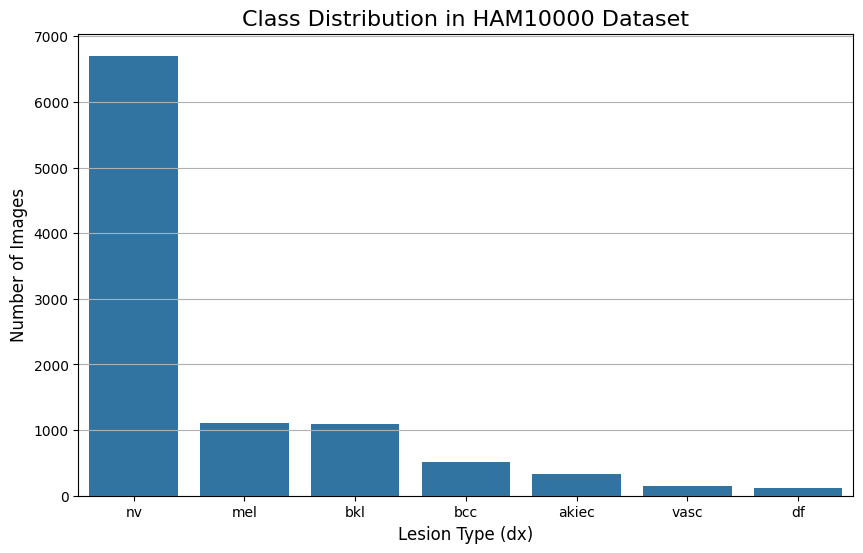

In [16]:
# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values)

plt.title('Class Distribution in HAM10000 Dataset', fontsize=16)
plt.xlabel('Lesion Type (dx)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(axis='y')
plt.show()

In [17]:
df['image_path'] = df['image_id'].apply(lambda x: f"{x}.jpg") # add image_path column

# Split Dataset (by lesion_id)

In [18]:
from sklearn.model_selection import train_test_split

lesions = df['lesion_id'].unique()

# First split into train+val and test (e.g., 80% train_val, 20% test)
train_val_lesions, test_lesions = train_test_split(lesions, test_size=0.2, random_state=42, stratify=df.groupby('lesion_id')['dx'].first())

# Then split train+val into train and val (e.g., 80% train, 20% val)
train_lesions, val_lesions = train_test_split(train_val_lesions, test_size=0.25, random_state=42, stratify=df[df['lesion_id'].isin(train_val_lesions)].groupby('lesion_id')['dx'].first())

# Create DataFrames
train_df = df[df['lesion_id'].isin(train_lesions)].reset_index(drop=True)
val_df = df[df['lesion_id'].isin(val_lesions)].reset_index(drop=True)
test_df = df[df['lesion_id'].isin(test_lesions)].reset_index(drop=True)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Train samples: 6045
Validation samples: 1994
Test samples: 1976


# Label Encoding

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_df['dx'])

train_df['label'] = le.transform(train_df['dx'])
val_df['label'] = le.transform(val_df['dx'])
test_df['label'] = le.transform(test_df['dx'])

print("Classes:", le.classes_)

Classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [20]:
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,label
0,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg,2
1,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,ISIC_0027850.jpg,2
2,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,ISIC_0029176.jpg,2
3,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,ISIC_0029068.jpg,2
4,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,ISIC_0025837.jpg,2


# Calcualate Class Weights (Training Set)

In [21]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['dx']),
    y=df['dx']
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(4.375273044997815), 1: np.float64(2.78349082823791), 2: np.float64(1.301832835044846), 3: np.float64(12.440993788819876), 4: np.float64(1.2854575792581184), 5: np.float64(0.21338020666879728), 6: np.float64(10.075452716297788)}


# Build Data Pipeline (Preprocessing and Augmentation)

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values from 0-255 to 0-1
    rotation_range=20,         # Randomly rotate images upto 20 degrees
    horizontal_flip=True,      # Randomly flip images horizontally
    vertical_flip=True,        # Randomly flip images vertically
    zoom_range=0.2             # Randomly zoom images by up to 20%
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg


In [24]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='data/Images_combined_10015',
    x_col='image_path',
    y_col='dx',
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='data/Images_combined_10015',
    x_col='image_path',
    y_col='dx',
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 6045 validated image filenames belonging to 7 classes.
Found 1994 validated image filenames belonging to 7 classes.


# Load Base Model (VGG16)

In [43]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


image_size = (224,224)
image_shape = image_size + (3,)
num_classes = len(df['dx'].unique())

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=image_shape
)

for layer in base_model.layers:
    layer.trainable = False  # Freeze so weights don’t change during training


In [48]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# Add custom classification head

In [45]:
x = base_model.output
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes,activation="softmax")(x)

model = Model(inputs=base_model.input,outputs=output_layer)

# Compile the model

In [46]:
model.compile(
    loss="categorical_crossenropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [47]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,271 (80.64 MB)

 Trainable params: 6,424,583 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Add EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)